In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/phishing-site-urls/phishing_site_urls.csv


## The Goal of this notebook is to analyse the change in the accuracy, precision, and recall vs the change in the training percentage

# Import the libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense

# Read the data

In [3]:
df = pd.read_csv("../input/phishing-site-urls/phishing_site_urls.csv")
print(df.shape)
df.head()

(549346, 2)


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [4]:
df.Label.value_counts()

good    392924
bad     156422
Name: Label, dtype: int64

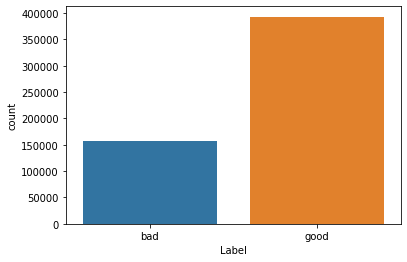

In [5]:
sns.countplot(data=df, x="Label")
plt.show()

# Shuffle the data

In [6]:
df_shuffled = shuffle(df, random_state=42)

# Choose 5000 samples

In [7]:
data_size = 5000

In [8]:
df_used = df_shuffled[:data_size].copy()

# Make sure the distribution is the same after taking the sample

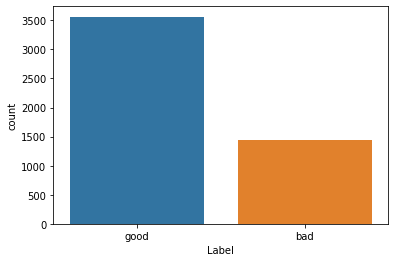

In [9]:
sns.countplot(data=df_used, x="Label")
plt.show()

In [10]:
df_used.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 452638 to 170545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URL     5000 non-null   object
 1   Label   5000 non-null   object
dtypes: object(2)
memory usage: 246.2+ KB


# Replace the labels

In [11]:
df_used.replace({'good':0, 'bad':1}, inplace=True)

In [12]:
df_used.Label.value_counts()

0    3562
1    1438
Name: Label, dtype: int64

# Divide the data into features and labels

In [13]:
X = df_used[['URL']].copy()
y = df_used.Label.copy()

# Initialize the tokenizer, stemmer, and Vectorizer

In [14]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")
cv = CountVectorizer()

# Prepare the data

In [15]:
def prepare_data(X) :
    X['text_tokenized'] = X.URL.map(lambda t: tokenizer.tokenize(t))
    X['text_stemmed'] = X.text_tokenized.map(lambda t: [stemmer.stem(word) for word in t])
    X['text_sent'] = X.text_stemmed.map(lambda t: ' '.join(t))
    features = cv.fit_transform(X.text_sent)
    return X, features

In [16]:
X, features = prepare_data(X)

# Import and intitialize the models

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [18]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svc = SVC()

# Train and test the models using different training percentages

In [19]:
def train_test_model(model, X, y, training_percentage) :
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=1-training_percentage, stratify=y, random_state=42)
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    accuracy = accuracy_score(testY, predY)
    precision = precision_score(testY, predY, pos_label=1)
    recall = recall_score(testY, predY, pos_label=1)
    return accuracy, precision, recall  

In [20]:
training_sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [21]:
def model_results(model) :
    results = []
    for p in training_sizes :
        results.append(train_test_model(model, features, y, p))
    return pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall'])

In [22]:
logreg_results = model_results(logreg)
knn_results = model_results(knn)
dtree_results = model_results(dtree)
rfc_results = model_results(rfc)
svc_results = model_results(svc)

In [23]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM']
model_results = [logreg_results, knn_results, dtree_results, rfc_results, svc_results]

In [24]:
accuracies = []
precisions = []
recalls = []
for model in model_results :
    accuracies.append(model.Accuracy.values)
    precisions.append(model.Precision.values)
    recalls.append(model.Recall.values)

In [25]:
accuracies = pd.DataFrame(np.transpose(accuracies), columns=models, index=training_sizes*100)
precisions = pd.DataFrame(np.transpose(precisions), columns=models, index=training_sizes*100)
recalls = pd.DataFrame(np.transpose(recalls), columns=models, index=training_sizes*100)

In [26]:
accuracies

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM
10.0,0.830667,0.739778,0.826222,0.846000,0.783111
20.0,0.863500,0.727750,0.850250,0.868500,0.832750
30.0,0.881429,0.726286,0.855429,0.884286,0.847143
40.0,0.885667,0.736000,0.852000,0.886667,0.856333
50.0,0.892400,0.750800,0.862400,0.891600,0.864400
60.0,0.900500,0.750000,0.862500,0.896500,0.872500
70.0,0.909394,0.765490,0.874750,0.899400,0.880746
80.0,0.902000,0.742000,0.883000,0.900000,0.878000
90.0,0.896000,0.738000,0.876000,0.888000,0.872000


In [27]:
precisions

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM
10.0,0.915625,0.557423,0.809179,0.914483,0.954286
20.0,0.914835,0.526091,0.826036,0.897959,0.925664
30.0,0.920455,0.521548,0.838057,0.928775,0.918440
40.0,0.901235,0.538883,0.799714,0.922456,0.892727
50.0,0.894737,0.564000,0.810945,0.939216,0.889344
60.0,0.917778,0.560976,0.821888,0.922018,0.937158
70.0,0.930233,0.590498,0.831522,0.937695,0.937716
80.0,0.916667,0.546296,0.830116,0.927273,0.932292
90.0,0.933962,0.538922,0.847458,0.931373,0.925532


In [28]:
recalls

,Logistic Regression,KNN,Decision Tree,Random Forest,SVM
10.0,0.452859,0.461360,0.517774,0.512365,0.258114
20.0,0.579130,0.534783,0.606957,0.612174,0.454783
30.0,0.643496,0.588878,0.616683,0.647468,0.514399
40.0,0.676709,0.570104,0.647740,0.661645,0.568946
50.0,0.709318,0.588317,0.680111,0.666203,0.603616
60.0,0.718261,0.600000,0.666087,0.699130,0.596522
70.0,0.740741,0.604167,0.708333,0.696759,0.627315
80.0,0.725694,0.614583,0.746528,0.708333,0.621528
90.0,0.687500,0.625000,0.694444,0.659722,0.604167


# Plot the accuracy, precision, and recall of the 5 models

Text(0, 0.5, 'Accuracy')

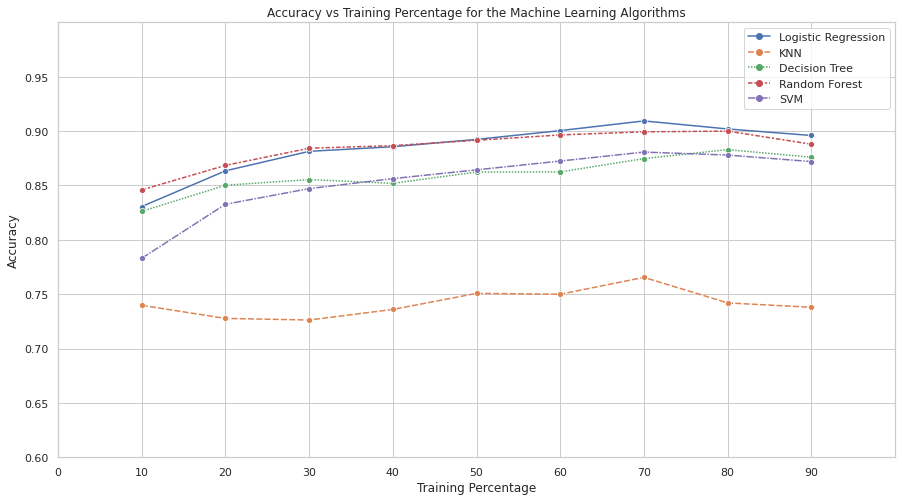

In [29]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = accuracies, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.6,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.6, 1, 0.05))
g.set_title("Accuracy vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Accuracy")

Text(0, 0.5, 'Precision')

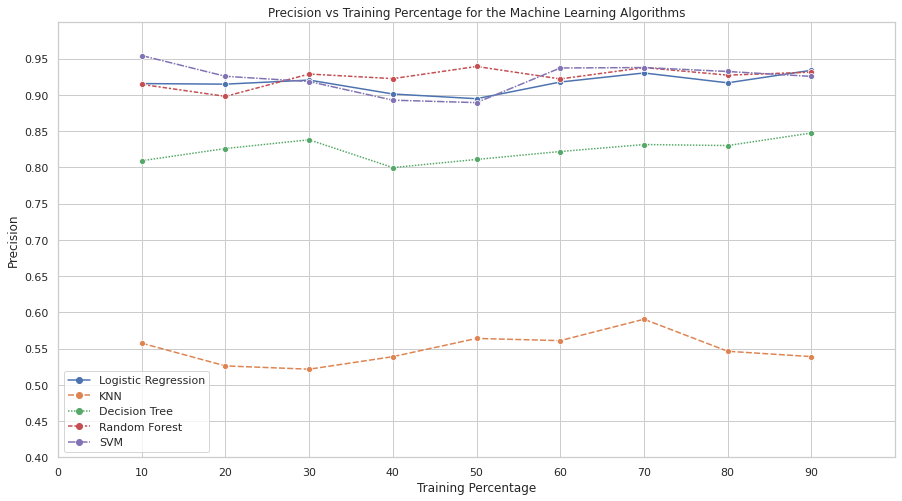

In [30]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = precisions, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.4,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.4, 1, 0.05))
g.set_title("Precision vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Precision")

Text(0, 0.5, 'Recall')

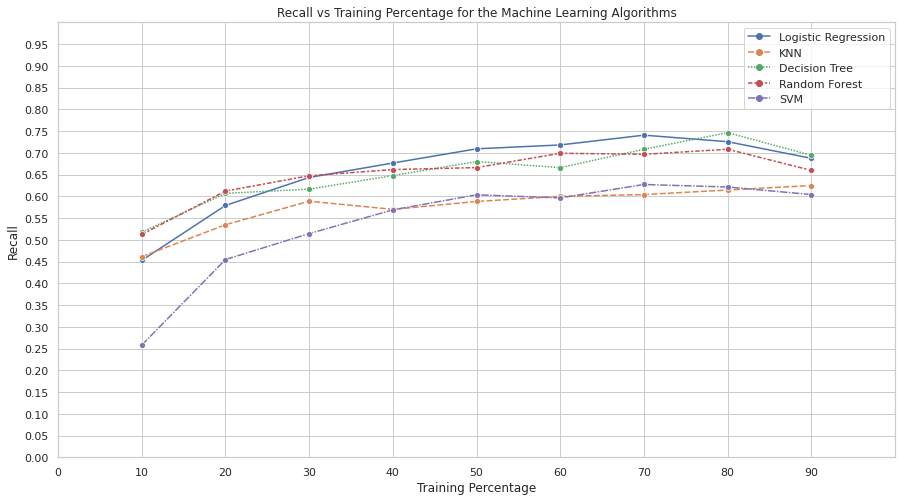

In [31]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = recalls, markers= ['o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0, 1, 0.05))
g.set_title("Recall vs Training Percentage for the Machine Learning Algorithms")
g.set_xlabel("Training Percentage")
g.set_ylabel("Recall")

# Let's do the same with a feed forward neural network
We can also test the impact of the number of hidden units as well

In [32]:
hidden_units = [2, 4, 6, 8, 10, 12, 14, 16, 18]

In [33]:
def train_test_nn(X, y, training_percentage, hidden_units) :
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=1-training_percentage, stratify=y, random_state=42)
    trainX = trainX.toarray()
    testX = testX.toarray()
    trainY = np.array(trainY)
    testY = np.array(testY)
    model = Sequential()
    model.add(Input(shape=(trainX.shape[1], ), name='Input-Layer'))
    model.add(Dense(hidden_units, activation='relu', name='Hidden-Layer'))
    model.add(Dense(1, activation='sigmoid', name='Output-Layer'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy', 'Precision', 'Recall'])
    model.fit(trainX, trainY, batch_size = 10, epochs = 10, verbose=0)
    score = model.evaluate(testX, testY, batch_size = 1, verbose=2)
    return score

In [34]:
accuracies_nn = []
precisions_nn = []
recalls_nn = []
for ts in training_sizes :
    a = []
    p = []
    r = []
    for hn in hidden_units :
        s = train_test_nn(features, y, ts, hn)
        a.append(s[1])
        p.append(s[2])
        r.append(s[3])
    accuracies_nn.append(a)
    precisions_nn.append(p)
    recalls_nn.append(r)

2022-07-04 12:00:26.321076: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-04 12:00:26.527680: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4500/4500 - 7s - loss: 0.4639 - Accuracy: 0.7960 - precision: 0.9947 - recall: 0.2921
4500/4500 - 7s - loss: 0.4088 - Accuracy: 0.8089 - precision: 0.9844 - recall: 0.3408
4500/4500 - 7s - loss: 0.3721 - Accuracy: 0.8400 - precision: 0.9484 - recall: 0.4691
4500/4500 - 7s - loss: 0.3637 - Accuracy: 0.8469 - precision: 0.9455 - recall: 0.4961
4500/4500 - 7s - loss: 0.3581 - Accuracy: 0.8509 - precision: 0.9297 - recall: 0.5209
4500/4500 - 7s - loss: 0.3454 - Accuracy: 0.8607 - precision: 0.9174 - recall: 0.5665
4500/4500 - 7s - loss: 0.3405 - Accuracy: 0.8564 - precision: 0.9197 - recall: 0.5487
4500/4500 - 7s - loss: 0.3329 - Accuracy: 0.8696 - precision: 0.8915 - recall: 0.6221
4500/4500 - 6s - loss: 0.3317 - Accuracy: 0.8664 - precision: 0.8933 - recall: 0.6082
4000/4000 - 6s - loss: 0.4644 - Accuracy: 0.8767 - precision: 0.8418 - recall: 0.7035
4000/4000 - 6s - loss: 0.3001 - Accuracy: 0.8775 - precision: 0.9156 - recall: 0.6322
4000/4000 - 6s - loss: 0.2839 - Accuracy: 0.8810 - pre

In [35]:
accuracies_nn_df = pd.DataFrame(accuracies_nn, columns=hidden_units, index=training_sizes*100)
precisions_nn_df = pd.DataFrame(precisions_nn, columns=hidden_units, index=training_sizes*100)
recalls_nn_df = pd.DataFrame(recalls_nn, columns=hidden_units, index=training_sizes*100)

In [36]:
accuracies_nn_df

,2,4,6,8,10,12,14,16,18
10.0,0.796000,0.808889,0.840000,0.846889,0.850889,0.860667,0.856444,0.869556,0.866444
20.0,0.876750,0.877500,0.881000,0.886750,0.893750,0.894500,0.898750,0.897750,0.894750
30.0,0.884000,0.900000,0.862857,0.901429,0.902857,0.905143,0.904286,0.902000,0.903143
40.0,0.894667,0.908000,0.907667,0.909333,0.907333,0.909333,0.909000,0.910000,0.911000
50.0,0.911200,0.916000,0.912400,0.913600,0.916000,0.916800,0.916800,0.917600,0.918400
60.0,0.913000,0.921000,0.917000,0.919500,0.919500,0.919500,0.918000,0.917000,0.917500
70.0,0.926049,0.925383,0.922718,0.924051,0.922718,0.921386,0.918055,0.920053,0.918721
80.0,0.914000,0.917000,0.917000,0.916000,0.913000,0.916000,0.916000,0.915000,0.913000
90.0,0.916000,0.912000,0.922000,0.920000,0.924000,0.922000,0.920000,0.922000,0.924000


In [37]:
precisions_nn_df

,2,4,6,8,10,12,14,16,18
10.0,0.994737,0.984375,0.948438,0.945508,0.929655,0.917397,0.919689,0.891473,0.893303
20.0,0.841831,0.915617,0.914005,0.887653,0.891892,0.879167,0.886010,0.879222,0.876939
30.0,0.901202,0.880649,0.958261,0.883991,0.878547,0.888377,0.871681,0.873034,0.871111
40.0,0.893525,0.882660,0.879534,0.881290,0.879377,0.875476,0.879177,0.876747,0.884021
50.0,0.897600,0.895801,0.854108,0.887519,0.899529,0.903633,0.898596,0.896445,0.899225
60.0,0.883365,0.911243,0.918200,0.895038,0.904297,0.904297,0.894434,0.895551,0.905138
70.0,0.925729,0.908163,0.901015,0.891626,0.905128,0.892500,0.885287,0.897959,0.883663
80.0,0.894531,0.898833,0.892720,0.889313,0.873606,0.886364,0.883459,0.880150,0.879245
90.0,0.932203,0.931035,0.920000,0.906250,0.920635,0.913386,0.912698,0.913386,0.927419


In [38]:
recalls_nn_df

,2,4,6,8,10,12,14,16,18
10.0,0.292117,0.340804,0.469088,0.496136,0.520866,0.566461,0.548686,0.622102,0.608192
20.0,0.703478,0.632174,0.646957,0.693913,0.717391,0.733913,0.743478,0.746957,0.737391
30.0,0.670308,0.754717,0.547170,0.756703,0.768620,0.766634,0.782522,0.771599,0.778550
40.0,0.719583,0.784473,0.786790,0.791425,0.785632,0.798378,0.792584,0.799537,0.794901
50.0,0.780250,0.801113,0.838665,0.801113,0.796940,0.795549,0.801113,0.806676,0.806676
60.0,0.803478,0.803478,0.780870,0.815652,0.805217,0.805217,0.810435,0.805217,0.796522
70.0,0.807870,0.824074,0.821759,0.837963,0.817130,0.826389,0.821759,0.814815,0.826389
80.0,0.795139,0.802083,0.809028,0.809028,0.815972,0.812500,0.815972,0.815972,0.809028
90.0,0.763889,0.750000,0.798611,0.805556,0.805556,0.805556,0.798611,0.805556,0.798611


Text(0, 0.5, 'Accuracy')

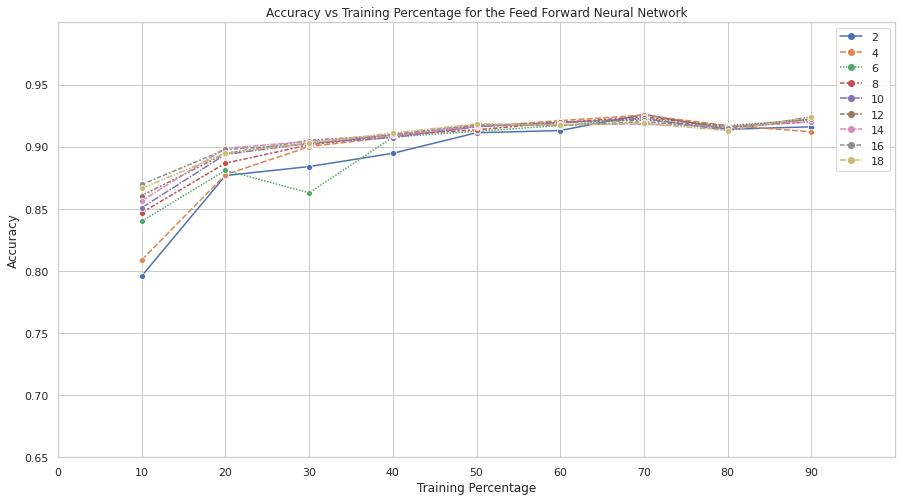

In [39]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = accuracies_nn_df, markers= ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0.65,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0.65, 1, 0.05))
g.set_title("Accuracy vs Training Percentage for the Feed Forward Neural Network")
g.set_xlabel("Training Percentage")
g.set_ylabel("Accuracy")

Text(0, 0.5, 'Precision')

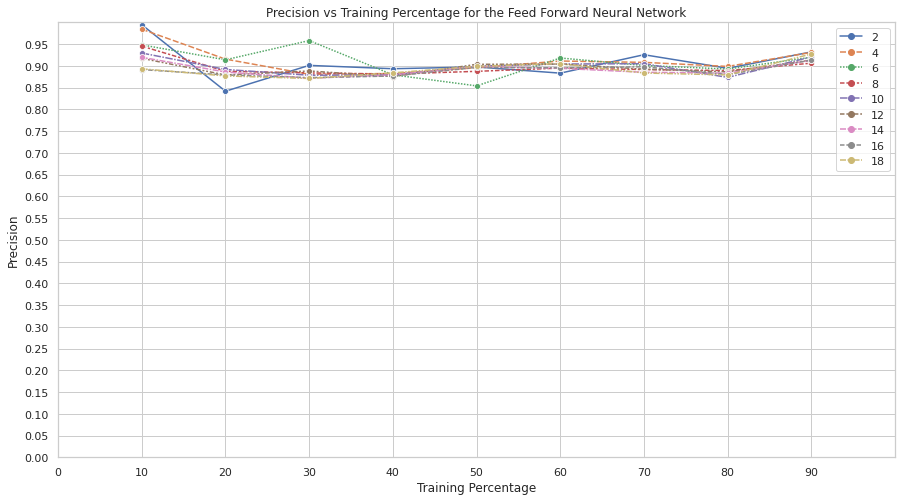

In [40]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = precisions_nn_df, markers= ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0, 1, 0.05))
g.set_title("Precision vs Training Percentage for the Feed Forward Neural Network")
g.set_xlabel("Training Percentage")
g.set_ylabel("Precision")

Text(0, 0.5, 'Recall')

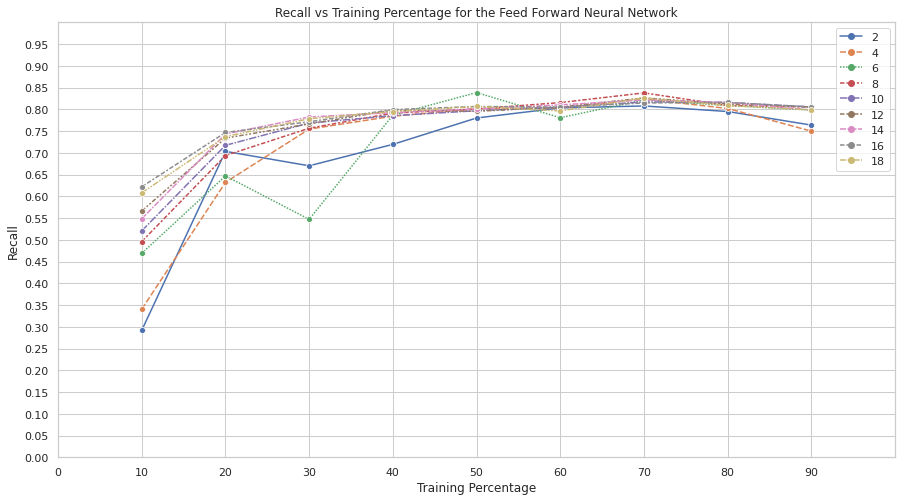

In [41]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style('whitegrid')
g = sns.lineplot(data = recalls_nn_df, markers= ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o'])
g.set(xlim = (0,100), ylim = (0,1), xticks = np.arange(0, 100, 10), yticks = np.arange(0, 1, 0.05))
g.set_title("Recall vs Training Percentage for the Feed Forward Neural Network")
g.set_xlabel("Training Percentage")
g.set_ylabel("Recall")

In [42]:
# df_used2 = df_shuffled[:50000].copy()
# df_used2.replace({'good':0, 'bad':1}, inplace=True)
# X2 = df_used2[['URL']].copy()
# y2 = df_used2.Label.copy()
# X2, features2 = prepare_data(X2)

In [43]:
# logreg2 = LogisticRegression(max_iter=1000)
# knn2 = KNeighborsClassifier()
# dtree2 = DecisionTreeClassifier()
# rfc2 = RandomForestClassifier()
# svc2 = SVC()

In [44]:
# print(train_test_model(logreg2, features2, y2, 0.8))
# print(train_test_model(knn2, features2, y2, 0.8))
# print(train_test_model(dtree2, features2, y2, 0.8))
# print(train_test_model(rfc2, features2, y2, 0.8))
# print(train_test_model(svc2, features2, y2, 0.8))